In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sparse_stoch_mat_central as sp_stoch_mat
import sys
from scipy.sparse.linalg import spsolve
import timeit
sys.path.append('/home/hcleroy/Extra_Module_py/')
from formated_matplotlib import *
from functions import *

In [2]:
V0a, V0b, V0c = 0.5,1.,2.#2.,2.6,4.
kab0,kbc0,kac0 = 1.,1.,1.
Aab,Abc,Aac = 1.,1.,1. # != 1 -> ooe
X0,Xf,n = -5,5,10000 # lower/higher spacial boundary and number of discretizing points
dx = (Xf-X0)/n
print('dx = '+str(dx))
Eab,Ebc,Eac = 0.,0.,0.
steepA,steepB,steepC = .5,.5,0.5
# define all the Vs :
Va = lambda x : 0.5*(1+np.tanh(steepA*x)) * V0a
Vb = lambda x : 0.5*(1+np.tanh(steepB*x)) * V0b
Vc = lambda x : 0.5*(1+np.tanh(steepC*x)) * V0c
""""
# define all the k's
kab = lambda x,*arg : kab0 * np.exp(Va(x)+Eab)*arg[0] # arg is the activity
kba = lambda x,*arg : kab0 * np.exp(Vb(x)+Eab) # no activity but it takes the same argument as kab
kbc = lambda x,*arg : kbc0 * np.exp(Vb(x)+Ebc)*arg[0] # arg is the activity
kcb = lambda x,*arg : kbc0 * np.exp(Vc(x)+Ebc) # no activity but it takes the same argument as kbc
kac = lambda x,*arg : kac0 * np.exp(Va(x)+Eac)*arg[0] # arg is the activity
kca = lambda x,*arg : kac0 * np.exp(Vc(x)+Eac) # no activity but it takes the same argument as kac
"""
# define all the k's
kab = lambda X,*arg : np.array([kab0 * np.exp(max(0,Va(x)-Vb(x))+Eab)*arg[0] for x in X]) if type(X) == np.ndarray else kab0 * np.exp(max(0,Va(X)-Vb(X))+Eab)*arg[0] # arg is the activity
kba = lambda X,*arg : np.array([kab0 * np.exp(max(0,Vb(x)-Va(x))+Eab)for x in X]) if type(X)==np.ndarray else kab0 * np.exp(max(0,Vb(X)-Va(X))+Eab)# no activity but it takes the same argument as kab
kbc = lambda X,*arg : np.array([kbc0 * np.exp(max(0,Vb(x)-Vc(x))+Ebc)*arg[0]for x in X]) if type(X)==np.ndarray else kbc0 * np.exp(max(0,Vb(X)-Vc(X))+Ebc)*arg[0]# arg is the activity
kcb = lambda X,*arg : np.array([kbc0 * np.exp(max(0,Vc(x)-Vb(x))+Ebc)for x in X]) if type(X) == np.ndarray else kbc0 * np.exp(max(0,Vc(X)-Vb(X))+Ebc)# no activity but it takes the same argument as kbc
kac = lambda X,*arg : np.array([kac0 * np.exp(max(0,Va(x)-Vc(x))+Eac)*arg[0]for x in X]) if type(X) ==np.ndarray else kac0 * np.exp(max(0,Va(X)-Vc(X))+Eac)*arg[0]# arg is the activity
kca = lambda X,*arg : np.array([kac0 * np.exp(max(0,Vc(x)-Va(x))+Eac)for x in X]) if type(X) == np.ndarray else kac0 * np.exp(max(0,Vc(X)-Va(X))+Eac)# no activity but it takes the same argument as kac

dx = 0.001


Start by checking the analytical results for the equilibrium case :
The solution for the chemical part does not fix entirely the value of $P_i$, we write is as:
$$
\begin{aligned}
&P_{a,\chi}(x) = 3/S \\
&P_{b,\chi}(x) = 3e^{V_a}/S \\
&P_{c,\chi}(x) = 3e^{V_a}/S
\end{aligned}
$$
$S$ can be defined as : $S = \int \text{d}x P_{a,\chi}(x)+P_{b,\chi}(x)+P_{b,\chi}(x)$

We can also define the diffusion solution as :
$$
\begin{aligned}
&P_{a,diff}(x) = e^{-V_a}/Z \\
&P_{b,diff}(x) = 1/Z\\
&P_{c,diff}(x) = 1/Z
\end{aligned}
$$
With $Z = \int \text{d}x P_{a,diff}(x)+P_{b,diff}(x)+P_{b,diff}(x)$

For these solutions to be consistent together, we write the relation between the normalization constants:
$$
S = 3e^{V_a}Z
$$
Finally considering $\int \text{d}x P_{a,diff}(x)+P_{b,diff}(x)+P_{c,diff}(x)=1$ gives us $Z$

In [3]:
# we first compute the non-normalized diffusion part : 
rho_a_diff,rho_b_diff,rho_c_diff = make_eq_distrib(Va,Vb,Vc,np.linspace(X0,Xf,n,endpoint=False))
# compute the normalization
Z = (sum(rho_a_diff)+sum(rho_b_diff)+sum(rho_c_diff))*dx
# normalize the diffusion part :
rho_a_diff,rho_b_diff,rho_c_diff =rho_a_diff/Z,rho_b_diff/Z,rho_c_diff/Z
# compute the non-normalized chemical part
rho_a_chem,rho_b_chem,rho_c_chem = make_chem_eq(kab,kba,kac,kca,kbc,kcb,Aab,Aac,Abc,np.linspace(X0,Xf,n,endpoint=False))
# compute the normalization for consistency :
S = 3*np.exp(Va(np.linspace(X0,Xf,n,endpoint=False)))*Z
# normalize the chemical part :
rho_a_chem,rho_b_chem,rho_c_chem = rho_a_chem/S,rho_b_chem/S,rho_c_chem/S

In [4]:
Eq_Stoch_Mat = sp_stoch_mat.make_transition_matrix(Va,Vb,Vc,
                                    kab,kba,kbc,kcb,kac,kca,
                                    kab0,kbc0,kac0,
                                    Aab=1.,Abc=1.,Aac=1.,
                                    X0=X0,Xf=Xf,n=n)
rho_a_eq,rho_b_eq,rho_c_eq = get_kernel_stoch_mat(Eq_Stoch_Mat,dx)

In [5]:
Ooe_Stoch_Mat = sp_stoch_mat.make_transition_matrix(Va,Vb,Vc,
                                    kab,kba,kbc,kcb,kac,kca,
                                    kab0,kbc0,kac0,
                                    Aab=Aab,Abc=Abc,Aac=Aac,
                                    X0=X0,Xf=Xf,n=n)
rho_a_ooe,rho_b_ooe,rho_c_ooe = get_kernel_stoch_mat(Ooe_Stoch_Mat,dx)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


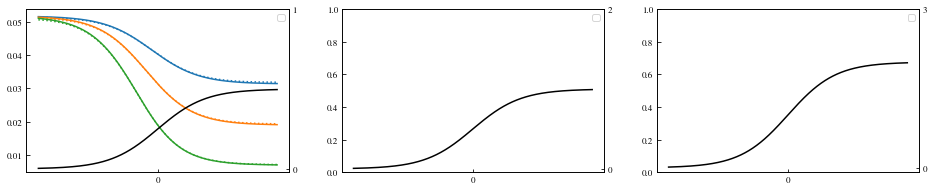

In [6]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

X = np.linspace(X0,Xf,n,endpoint=False)

ax[0].plot(X,rho_a_diff,color=ColorCycle[0])
#ax[0].plot(X,rho_a_chem,color=ColorCycle[0],linestyle='--')
ax[0].plot(X,rho_a_eq,color = ColorCycle[0],linestyle=':')
#ax[0].plot(X,rho_a_ooe,color = ColorCycle[0],linestyle='-.',label='A')
ax02 = ax[0].twinx()
ax02.plot(X,Va(X),color='black')

ax[0].plot(X,rho_b_diff,color=ColorCycle[1])
#ax[1].plot(X,rho_b_chem,color=ColorCycle[1],linestyle='--')
ax[0].plot(X,rho_b_eq,color = ColorCycle[1],linestyle=':')
#ax[0].plot(X,rho_b_ooe,color = ColorCycle[1],linestyle='-.',label='B')
ax12 = ax[1].twinx()
ax12.plot(X,Vb(X),color='black')

ax[0].plot(X,rho_c_diff,color=ColorCycle[2])
#ax[2].plot(X,rho_c_chem,color=ColorCycle[2],linestyle='--')
ax[0].plot(X,rho_c_eq,color = ColorCycle[2],linestyle=':')
#ax[0].plot(X,rho_c_ooe,color = ColorCycle[2],linestyle='-.',label='C')
ax22 = ax[2].twinx()
ax22.plot(X,Vc(X),color='black')

for i in range(3):
    ax[i].legend()
    ax[i].set_xticks([0])
    #ax[i].set_yticks([0.000])
ax02.set_yticks([0.,1.])
ax12.set_yticks([0.,2.])
ax22.set_yticks([0.,3.])

## All the equilibrium solutions are consistent
#### Check that the fluxes are 0 for the eq solution, and look at the fluxes for the non-eq solution

In [7]:
A_eq_diff__diff_flux = diff_flux(rho_a_diff,Va(X),dx)
A_eq_chem__diff_flux = diff_flux(rho_a_chem,Va(X),dx)
A_eq__diff_flux = diff_flux(rho_a_eq,Va(X),dx)
A_ooe__diff_flux = diff_flux(rho_a_ooe,Va(X),dx)

B_eq_diff__diff_flux = diff_flux(rho_b_diff,Vb(X),dx)
B_eq_chem__diff_flux = diff_flux(rho_b_chem,Vb(X),dx)
B_eq__diff_flux = diff_flux(rho_b_eq,Vb(X),dx)
B_ooe__diff_flux = diff_flux(rho_b_ooe,Vb(X),dx)

C_eq_diff__diff_flux = diff_flux(rho_c_diff,Vc(X),dx)
C_eq_chem__diff_flux = diff_flux(rho_c_chem,Vc(X),dx)
C_eq__diff_flux = diff_flux(rho_c_eq,Vc(X),dx)
C_ooe__diff_flux = diff_flux(rho_c_ooe,Vc(X),dx)

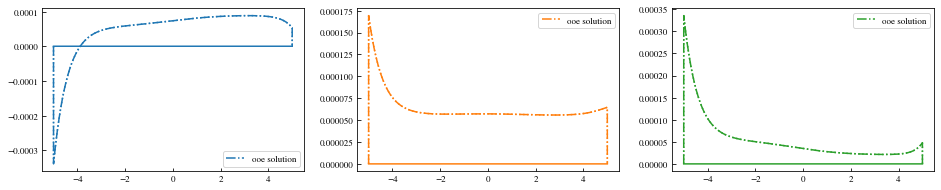

In [8]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

X = np.linspace(X0,Xf,n,endpoint=False)

ax[0].plot(X,A_eq_diff__diff_flux,color=ColorCycle[0])
#ax[0].plot(X,A_eq_chem__diff_flux,color=ColorCycle[0],linestyle='--')
ax[0].plot(X,A_eq__diff_flux,color = ColorCycle[0],linestyle=':')
ax[0].plot(X,A_ooe__diff_flux ,color = ColorCycle[0],linestyle='-.',label='ooe solution')

ax[1].plot(X,B_eq_diff__diff_flux,color=ColorCycle[1])
#ax[1].plot(X,B_eq_chem__diff_flux,color=ColorCycle[1],linestyle='--')
ax[1].plot(X,B_eq__diff_flux,color = ColorCycle[1],linestyle=':')
ax[1].plot(X,B_ooe__diff_flux,color = ColorCycle[1],linestyle='-.',label='ooe solution')

ax[2].plot(X,C_eq_diff__diff_flux,color=ColorCycle[2])
#ax[2].plot(X,C_eq_chem__diff_flux,color=ColorCycle[2],linestyle='--')
ax[2].plot(X,C_eq__diff_flux,color = ColorCycle[2],linestyle=':')
ax[2].plot(X,C_ooe__diff_flux,color = ColorCycle[2],linestyle='-.',label='ooe solution')

for i in range(3):
    ax[i].legend()

Text(0, 0.5, '$f_{\\chi,i}$')

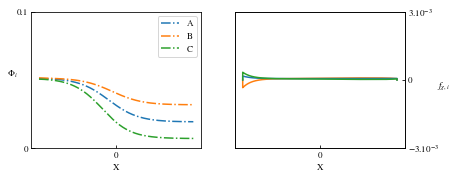

In [9]:
fig,ax = plt.subplots(ncols=2,figsize=(2.*8.5/2.54,8.5/2.54/1.33))
X = np.linspace(X0,Xf,n,endpoint=False)
#ax2 = ax[0].twinx()
ax[0].plot(X,rho_b_ooe,color = ColorCycle[0],linestyle='-.',label='A')
#ax2.plot(X,Vb(X),color= ColorCycle[0],linewidth=0.8)
ax[0].plot(X,rho_a_ooe,color = ColorCycle[1],linestyle='-.',label='B')
#ax2.plot(X,Va(X),color= ColorCycle[1],linewidth=0.8)
ax[0].plot(X,rho_c_ooe,color = ColorCycle[2],linestyle='-.',label='C')
#ax2.plot(X,Vc(X),color= ColorCycle[2],linewidth=0.8)
ax[0].set_xticks([0.])
ax[0].set_yticks([0,0.1],['0','0.1'])
#ax2.set_yticks([0.,1.,2.,3.])
ax[0].set_xlabel('X')
ax[0].set_ylabel(r'$\Phi_i$',rotation=0)
#ax2.set_ylabel(r'$V_i(X)$',rotation=0)
ax[0].legend()

ax1 = ax[1].twinx()
ax1.plot(X,A_ooe__diff_flux,label='A',color=ColorCycle[1])
ax1.plot(X,B_ooe__diff_flux,label='B',color=ColorCycle[0])
ax1.plot(X,C_ooe__diff_flux,label='C',color=ColorCycle[2])
ax[1].set_yticks([])
ax[1].set_xticks([0])
ax[1].set_xlabel('X')
ax1.set_yticks([-0.003,0.,0.003],[r'$-3.10^{-3}$','0',r'$3.10^{-3}$'])
ax1.set_ylabel(r'$f_{\chi,i}$',rotation=0)

#fig.savefig('/home/hcleroy/Dropbox/Apps/Overleaf/Synergia_Active_Phase_Sep/OOE_Fluxs.pdf',transparent=True,bbox_inches='tight')


In [10]:
print(np.sum(A_ooe__diff_flux))
print(np.sum(B_ooe__diff_flux))
print(np.sum(C_ooe__diff_flux))

0.48933925855565613
0.632482590426036
0.5334560734760166


In [11]:
print(np.sum(A_ooe__diff_flux))
print(np.sum(B_ooe__diff_flux))
print(np.sum(C_ooe__diff_flux))

0.48933925855565613
0.632482590426036
0.5334560734760166


-0.3932886508869699
0.10495825365571032
0.28833039723125836


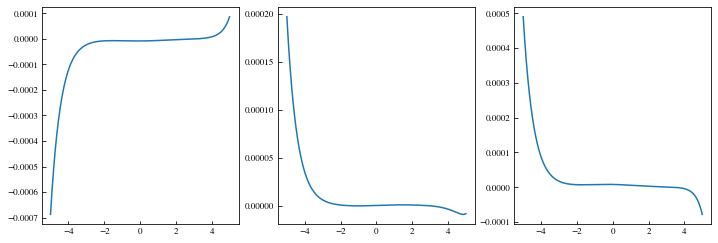

In [12]:

fig,ax = plt.subplots(ncols=3,figsize=(12,4))
X = np.linspace(X0,Xf,n,endpoint=False)
chem_A_ooe_flux = -kab(X,Aab)*rho_a_ooe+kba(X,Aab)*rho_b_ooe-kac(X,Aac)*rho_a_ooe+kca(X,Aac)*rho_c_ooe
chem_B_ooe_flux = kab(X,Aab)*rho_a_ooe-kba(X,Aab)*rho_b_ooe-kbc(X,Aac)*rho_b_ooe+kcb(X,Abc)*rho_c_ooe
chem_C_ooe_flux = kac(X,Aac)*rho_a_ooe-kca(X,Aac)*rho_c_ooe+kbc(X,Aac)*rho_b_ooe-kcb(X,Abc)*rho_c_ooe

#ax[0].plot(X,D(A_ooe__diff_flux,dx),label='D(diffusive)')
ax[0].plot(X,chem_A_ooe_flux,label='chemical')

#ax[1].plot(X,D(B_ooe__diff_flux,dx),label='D(diffusive)')
ax[1].plot(X,chem_B_ooe_flux,label='chemical')

#ax[2].plot(X,D(C_ooe__diff_flux,dx),label='D(diffusive)')
ax[2].plot(X,chem_C_ooe_flux,label='chemical')
print(sum(chem_A_ooe_flux))
print(sum(chem_B_ooe_flux))
print(sum(chem_C_ooe_flux))

-0.3932886508869699
0.10495825365571032
0.28833039723125836


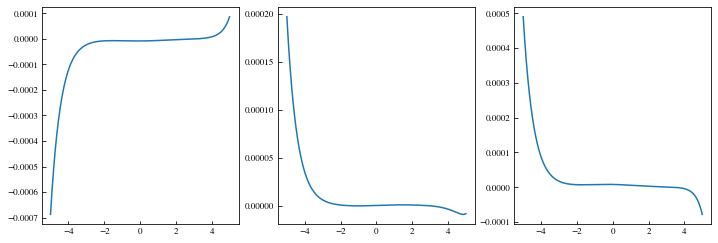

In [13]:

fig,ax = plt.subplots(ncols=3,figsize=(12,4))
X = np.linspace(X0,Xf,n,endpoint=False)
chem_A_ooe_flux = -kab(X,Aab)*rho_a_ooe+kba(X,Aab)*rho_b_ooe-kac(X,Aac)*rho_a_ooe+kca(X,Aac)*rho_c_ooe
chem_B_ooe_flux = kab(X,Aab)*rho_a_ooe-kba(X,Aab)*rho_b_ooe-kbc(X,Aac)*rho_b_ooe+kcb(X,Abc)*rho_c_ooe
chem_C_ooe_flux = kac(X,Aac)*rho_a_ooe-kca(X,Aac)*rho_c_ooe+kbc(X,Aac)*rho_b_ooe-kcb(X,Abc)*rho_c_ooe

#ax[0].plot(X,D(A_ooe__diff_flux,dx),label='D(diffusive)')
ax[0].plot(X,chem_A_ooe_flux,label='chemical')

#ax[1].plot(X,D(B_ooe__diff_flux,dx),label='D(diffusive)')
ax[1].plot(X,chem_B_ooe_flux,label='chemical')

#ax[2].plot(X,D(C_ooe__diff_flux,dx),label='D(diffusive)')
ax[2].plot(X,chem_C_ooe_flux,label='chemical')
print(sum(chem_A_ooe_flux))
print(sum(chem_B_ooe_flux))
print(sum(chem_C_ooe_flux))

In [14]:
#ab, ac ,bc 
kajs_eq = np.array([lambda x : kab(x,1.),lambda x : kac(x,1.)])
kjas_eq = np.array([kba,kca])

kbjs_eq = np.array([kba,lambda x : kbc(x,1.)])
kjbs_eq = np.array([lambda x : kab(x,1.),kcb])

kcjs_eq = np.array([kca,kcb])
kjcs_eq = np.array([lambda x : kac(x,1.),lambda x : kbc(x,1.)])

kajs_ooe = np.array([lambda x : kab(x,Aab),lambda x : kac(x,Aac)])
kjas_ooe = np.array([kba,kca])

kbjs_ooe = np.array([kba,lambda x : kbc(x,Abc)])
kjbs_ooe = np.array([lambda x : kab(x,Aab),kcb])

kcjs_ooe = np.array([kca,kcb])
kjcs_ooe = np.array([lambda x : kac(x,Aac),lambda x : kbc(x,Abc)])

rho_a_js_eq = np.array([rho_b_eq,rho_c_eq])
rho_b_js_eq = np.array([rho_a_eq,rho_c_eq])
rho_c_js_eq = np.array([rho_a_eq,rho_b_eq])

rho_a_js_ooe = np.array([rho_b_ooe,rho_c_ooe])
rho_b_js_ooe = np.array([rho_a_ooe,rho_c_ooe])
rho_c_js_ooe = np.array([rho_a_ooe,rho_b_ooe])

A_Chem_flux_eq = np.array([chem_flux(kjas_eq,kajs_eq,rho_a_eq,rho_a_js_eq,i,X0+i*dx)*dx for i in range(n)])
B_Chem_flux_eq = np.array([chem_flux(kjbs_eq,kbjs_eq,rho_b_eq,rho_b_js_eq,i,X0+i*dx)*dx for i in range(n)])
C_Chem_flux_eq = np.array([chem_flux(kjcs_eq,kcjs_eq,rho_c_eq,rho_c_js_eq,i,X0+i*dx)*dx for i in range(n)])


A_Chem_flux_ooe = np.array([chem_flux(kjas_ooe,kajs_ooe,rho_a_ooe,rho_a_js_ooe,i,X0+i*dx)*dx for i in range(n)])
B_Chem_flux_ooe = np.array([chem_flux(kjbs_ooe,kbjs_ooe,rho_b_ooe,rho_b_js_ooe,i,X0+i*dx)*dx for i in range(n)])
C_Chem_flux_ooe = np.array([chem_flux(kjcs_ooe,kcjs_ooe,rho_c_ooe,rho_c_js_ooe,i,X0+i*dx)*dx for i in range(n)])


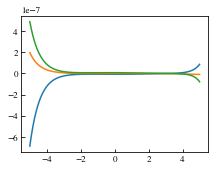

In [15]:
plt.plot(np.linspace(X0,Xf,n,endpoint=False),A_Chem_flux_ooe)
plt.plot(np.linspace(X0,Xf,n,endpoint=False),B_Chem_flux_ooe)
plt.plot(np.linspace(X0,Xf,n,endpoint=False),C_Chem_flux_ooe)

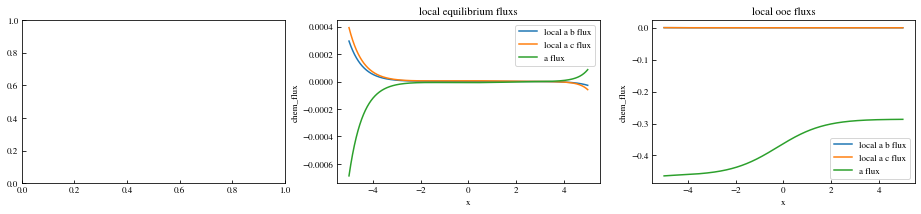

In [16]:
# local chem fluxes are : A->B and B->A

fig,ax = plt.subplots(figsize=(16,3),ncols=3)
# Stat mech checks that chem_flux are well computed


ab_flux = rho_a_eq*np.array([kab(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_b_eq*np.array([kba(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
ac_flux = rho_a_eq*np.array([kac(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_c_eq*np.array([kca(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
a_flux = np.array([chem_flux(np.array([kba,kca]),np.array([lambda x:kab(x,1.),lambda x:kac(x,1.)]),rho_a_eq,np.array([rho_b_eq,rho_c_eq]),i,i*dx+X0) for i in range(n)])
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),ab_flux,label='local a b flux')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),ac_flux,label='local a c flux')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),a_flux, label='a flux')
ax[1].set_title('local equilibrium fluxs')
ax[1].set_xlabel('x')
ax[1].set_ylabel('chem_flux')
ax[1].legend()

ab_flux = rho_a_ooe*np.array([kab(x,Aab) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_b_ooe*np.array([kba(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
ac_flux = rho_a_ooe*np.array([kac(x,Aac) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_c_ooe*np.array([kca(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
a_flux = np.array([chem_flux(np.array([kba,kca]),np.array([lambda x:kab(x,10.),lambda x:kac(x,1.)]),rho_a_ooe,np.array([rho_b_ooe,rho_c_ooe]),i,i*dx+X0) for i in range(n)])
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),ab_flux,label='local a b flux')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),ac_flux,label='local a c flux')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),a_flux, label='a flux')
ax[2].set_title('local ooe fluxs')
ax[2].set_xlabel('x')
ax[2].set_ylabel('chem_flux')
ax[2].legend()


In [17]:
print(np.sum([kab(x,Aab)*rho_a_ooe*dx for x in np.arange(-5,5,dx)]))

4109.428070069485


In [18]:
sum(rho_a_ooe*dx)

0.41094280700694347

#### Even the ooe solution has 0 fluxes